SAP-netのメインともいえる拡散について実装していく。

まずは何も考えず、全部に拡散し続ける。
新しい要素としては、拡散の２重ループ、計算式、適当な閾値である。

In [43]:
import sqlite3
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [44]:
def NetworkX(df):
    G = nx.DiGraph()

    # ノードを追加
    nodes = df.columns
    for node in nodes:
        G.add_node(node)

    # エッジを追加
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            distance = df.iloc[i, j]
            if i != j:  # iとjが同じでない場合のみエッジを追加
                if distance != 0.0:
                    G.add_edge(nodes[i], nodes[j], weight=distance)
            else:
                node_size = distance*1000  # iとjが同じ場合、ノードの大きさを設定
                G.nodes[nodes[i]]['size'] = node_size
                #閾値の視認性を高める
                threshold = 3.0
                print(distance,threshold,distance>threshold)
                if(distance>threshold):
                    node_color = 'red'  # ノードの色を赤に設定
                    G.nodes[nodes[i]]['color'] = node_color
                    
    # ネットワーク図を描画
    pos = nx.spring_layout(G)  # レイアウトを設定
    edge_labels = {(u, v): str(d['weight']) for u, v, d in G.edges(data=True)}
    
    node_sizes = [G.nodes[node].get('size', 500) for node in G.nodes]
    node_colors = [G.nodes[node].get('color', 'skyblue') for node in G.nodes]
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=10, font_color='black', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)  # エッジのラベルを表示
    plt.title("Network Graph")
    plt.show()

def DataFrameSelector(df,select_number):    # 指定の行数を取得
    select_number = select_number-1  # 例として1を指定
    selected_row = df.iloc[select_number][select_number]
    selected_list = selected_row.tolist()
    return selected_list

def SQL_SetUp(database_path):
    conn = sqlite3.connect(database_path)
    cursor = conn.cursor()

    # データベースファイルが存在する場合は処理を終了
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    existing_tables = cursor.fetchall()
    if existing_tables:
        print("Database already exists. Exiting setup.")
        conn.close()
        return

    # テーブルを作成
    cursor.execute('''
        CREATE TABLE knowledge (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            data TEXT,
            Adata FLOAT,
            Bdata FLOAT,
            Cdata FLOAT,
            Ddata FLOAT,
            Edata FLOAT,
            Fdata FLOAT
        )
    ''')

    # 配列の定義   
    data = [["Adata",1, 0.2, 0.2, 0, 0, 0],
            ["Bdata",0.2, 2, 0.1, 0.4, 0.4, 0],
            ["Cdata",0.2, 0.1, 3, 0, 0, 0.6],
            ["Ddata",0, 0.4, 0, 4, 0, 0],
            ["Edata",0, 0.4, 0, 0, 5, 0],
            ["Fdata",0, 0, 0.6, 0, 0, 6]]
    
    # データを挿入
    cursor.executemany("INSERT INTO knowledge (data, Adata, Bdata, Cdata, Ddata, Edata, Fdata) VALUES (?, ?, ?, ?, ?, ?, ?)", data)

    conn.commit()
    conn.close()


def SQL_GetData(database_path):
    conn = sqlite3.connect(database_path)
    cursor = conn.cursor()

    # データを取得してDataFrameに格納
    cursor.execute("SELECT * FROM knowledge")
    rows = cursor.fetchall()
    columns = [description[0] for description in cursor.description]
    df = pd.DataFrame(rows, columns=columns)

    conn.close()

    # "data"列をデータフレームのインデックスに設定
    df.set_index("data", inplace=True)
    # 不要な"id"列を削除
    df.drop("id", axis=1, inplace=True)

    return df


入力された刺激：stimulation_input
拡散先の刺激：stimulation


Database already exists. Exiting setup.
       Adata  Bdata  Cdata  Ddata  Edata  Fdata
data                                           
Adata    1.0    0.2    0.2    0.0    0.0    0.0
Bdata    0.2    2.0    0.1    0.4    0.4    0.0
Cdata    0.2    0.1    3.0    0.0    0.0    0.6
Ddata    0.0    0.4    0.0    4.0    0.0    0.0
Edata    0.0    0.4    0.0    0.0    5.0    0.0
Fdata    0.0    0.0    0.6    0.0    0.0    6.0
1.0 3.0 False
2.0 3.0 False
3.0 3.0 False
4.0 3.0 True
5.0 3.0 True
6.0 3.0 True


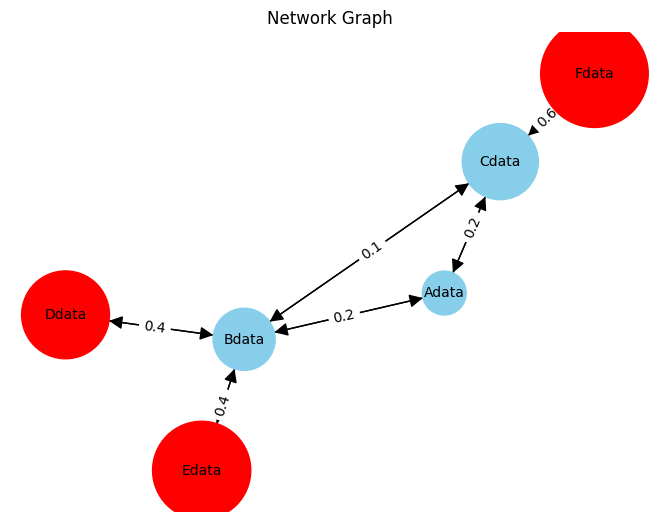

In [45]:
# データベースのセットアップ
SQL_SetUp("database_v04_copy.sqlite")

# データの取得
df = SQL_GetData("database_v04_copy.sqlite")

# データの表示
print(df)

# データの可視化
NetworkX(df)

パス数取得

In [52]:
def path_num_calc(df, stimulus_number):
    row_number = stimulus_number - 1  # 行番号を調整（0ベースの行番号に変換）
    selected_row = df.iloc[row_number]
    count_positive = 0  # 0以上の値のカウントを初期化
    for value in selected_row:
        if value > 0 and value!=stimulus_number:
            count_positive += 1  # 0以上の値があればカウントを増やす
    return count_positive

In [53]:
stimulus_number = 2
path_weight_num = path_num_calc(df, stimulus_number)
print(path_weight_num)

4


活性値の取得

In [48]:
def stimulus_value_calc(df, stimulus_number):
    row_number = stimulus_number - 1  # 行番号を調整（0ベースの行番号に変換）
    selected_row = df.iloc[row_number]
    stimulus_value = 0
    for value in selected_row:
        if value == stimulus_number:
            stimulus_value = value
            break  # 一致するノードが見つかればループを終了
    return stimulus_value


In [49]:
stimulus_value = stimulus_value_calc(df,stimulus_number)
print(stimulus_value)

2.0


パスの重み

In [54]:
def path_weight_calc(df, stimulus_number):
    row_number = stimulus_number-1  # 例として2を指定
    selected_row = df.iloc[row_number]
    for i in selected_row:
        selected_list = selected_row.tolist()
    return selected_list


In [55]:
path_weight = path_weight_calc(df,stimulus_number)
print(path_weight)

[0.2, 2.0, 0.1, 0.4, 0.4, 0.0]
